In [4]:
from pathlib import Path
from pprint import pformat
import logging
import json
import re

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

logging.basicConfig(format='%(levelname)-8s [%(filename)s] %(message)s',
                    level=logging.INFO)
matplotlib_logger = logging.getLogger("matplotlib")
matplotlib_logger.setLevel(logging.ERROR)
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False

time: 668 µs (started: 2023-02-24 01:21:23 +08:00)


In [5]:
def mts_corr_ad_estimation(log_path_list):
    for log_path in log_path_list:
        with open(log_path, "r") as source:
            log_dict = json.load(source)
            corr_info = [p for p in log_path.parts if p.startswith("corr")][0]
            best_epoch = log_dict['best_val_epoch'] if log_dict.get('best_val_epoch') else 4500
            min_val_loss = min(log_dict['val_loss_history'])
            tr_batch = log_dict.get('train_batch') if log_dict.get('train_batch') else None
            if log_dict.get('model_structure'):
                gin_l = len(re.findall("\(\d\)GINConv", log_dict.get('model_structure')))
                gin_h = re.search("(\(\d\)\:\sGINConv.*\n.*)(out_features\=)(\d*)", log_dict.get('model_structure')).group(3)
                gru_l = re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure'))[0][-1] if re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure')) else 1
                gru_h = re.search("(\(gru1\)\:\sGRU\(\d*\,)\s(\d*)", log_dict.get('model_structure')).group(2)
            else:
                gin_l = None
                gin_h = None
                gru_l = None
                gru_h = None
            logging.info(f"file_name:{log_path.parts}")
        # plot results
        fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(25,40))
        fig.suptitle(f'{corr_info} with tr_batch({tr_batch}) input to model with gin_l{gin_l}-gin_h{gin_h}-gru_l{gru_l}-gru_h{gru_h}; min val-loss:{min_val_loss:8f}', fontsize=30)
        gs = axs[0, 0].get_gridspec()
        # remove the upper axes
        for ncol in range(2):
            for ax in axs[2:, ncol]:
                ax.remove()
        axbig = fig.add_subplot(gs[2:, :2])
        axbig.set_xticks([]); axbig.set_yticks([])
        axbig.annotate(text=f"{log_dict.get('model_structure').__str__()}",
                       xy=(0.15, 0.5), bbox={'facecolor': 'green', 'alpha': 0.4, 'pad': 5},
                       fontsize=20, fontfamily='monospace', xycoords='axes fraction', va='center')
        axs[0, 0].plot(log_dict.get('train_loss_history'))
        axs[0, 1].plot(log_dict.get('val_loss_history'))
        axs[1, 0].plot(log_dict.get('train_loss_history')[max(0, best_epoch-250):max(501, best_epoch+251)])
        axs[1, 1].plot(log_dict.get('val_loss_history')[max(0, best_epoch-250):max(501, best_epoch+251)])
        axs[0, 0].set_title('train_loss_history', fontsize=30)
        axs[0, 1].set_title('val_loss_history', fontsize=30)
        axs[1, 0].set_title(f"train_loss_history-epoch{(max(0, best_epoch-250), max(500, best_epoch+250))}", fontsize=30)
        axs[1, 1].set_title(f"val_loss_history-epoch{(max(0, best_epoch-250), max(500, best_epoch+250))}", fontsize=30)
        axs[1, 0].set_xticks(ticks=range(0, 501, 100), labels=[f"{x:02d}" for x in range(max(0, best_epoch-250), max(501, best_epoch+251), 100)])
        axs[1, 1].set_xticks(ticks=range(0, 501, 100), labels=[f"{x:02d}" for x in range(max(0, best_epoch-250), max(501, best_epoch+251), 100)])
        for ax in axs.ravel():
            ax.yaxis.offsetText.set_fontsize(30)
            ax.tick_params(axis='both', which='major', labelsize=24)
        fig.tight_layout(rect=(0, 0, 1, 0.97))
        plt.show()
        plt.close()

time: 2.02 ms (started: 2023-02-24 01:21:24 +08:00)


INFO     [3603277661.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_99-20230224012026.json')


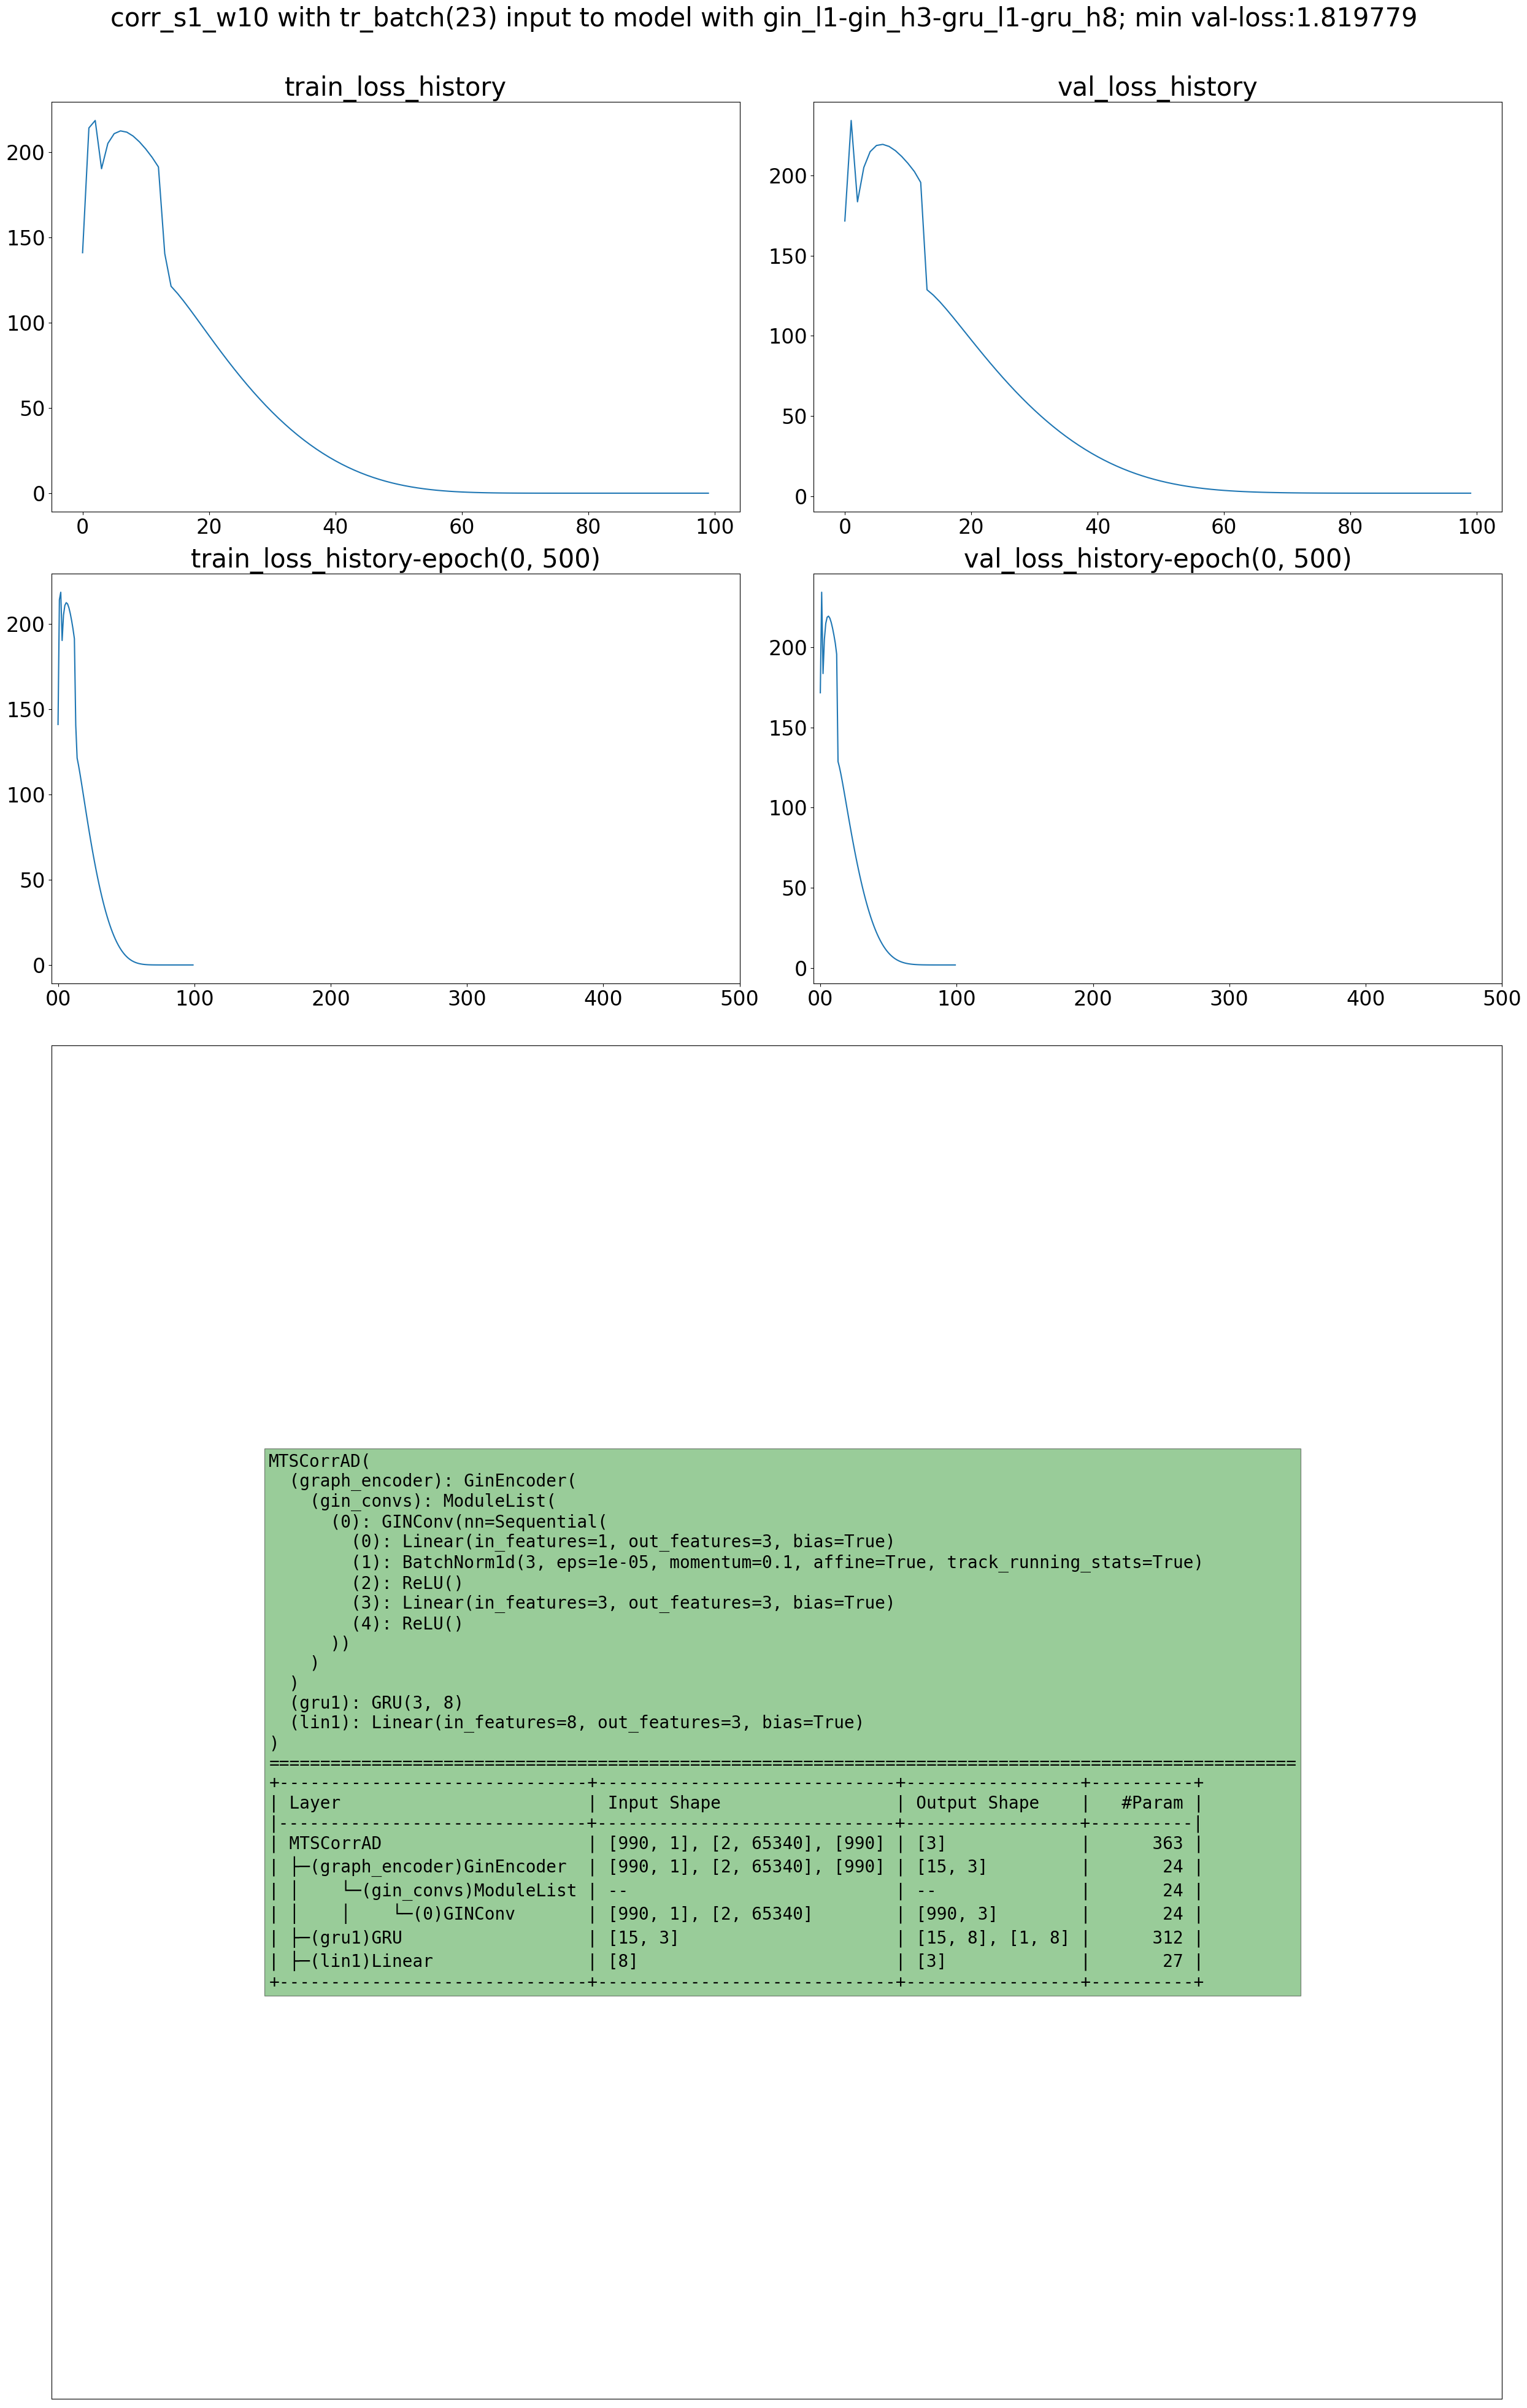

INFO     [3603277661.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_304-20230222215241.json')


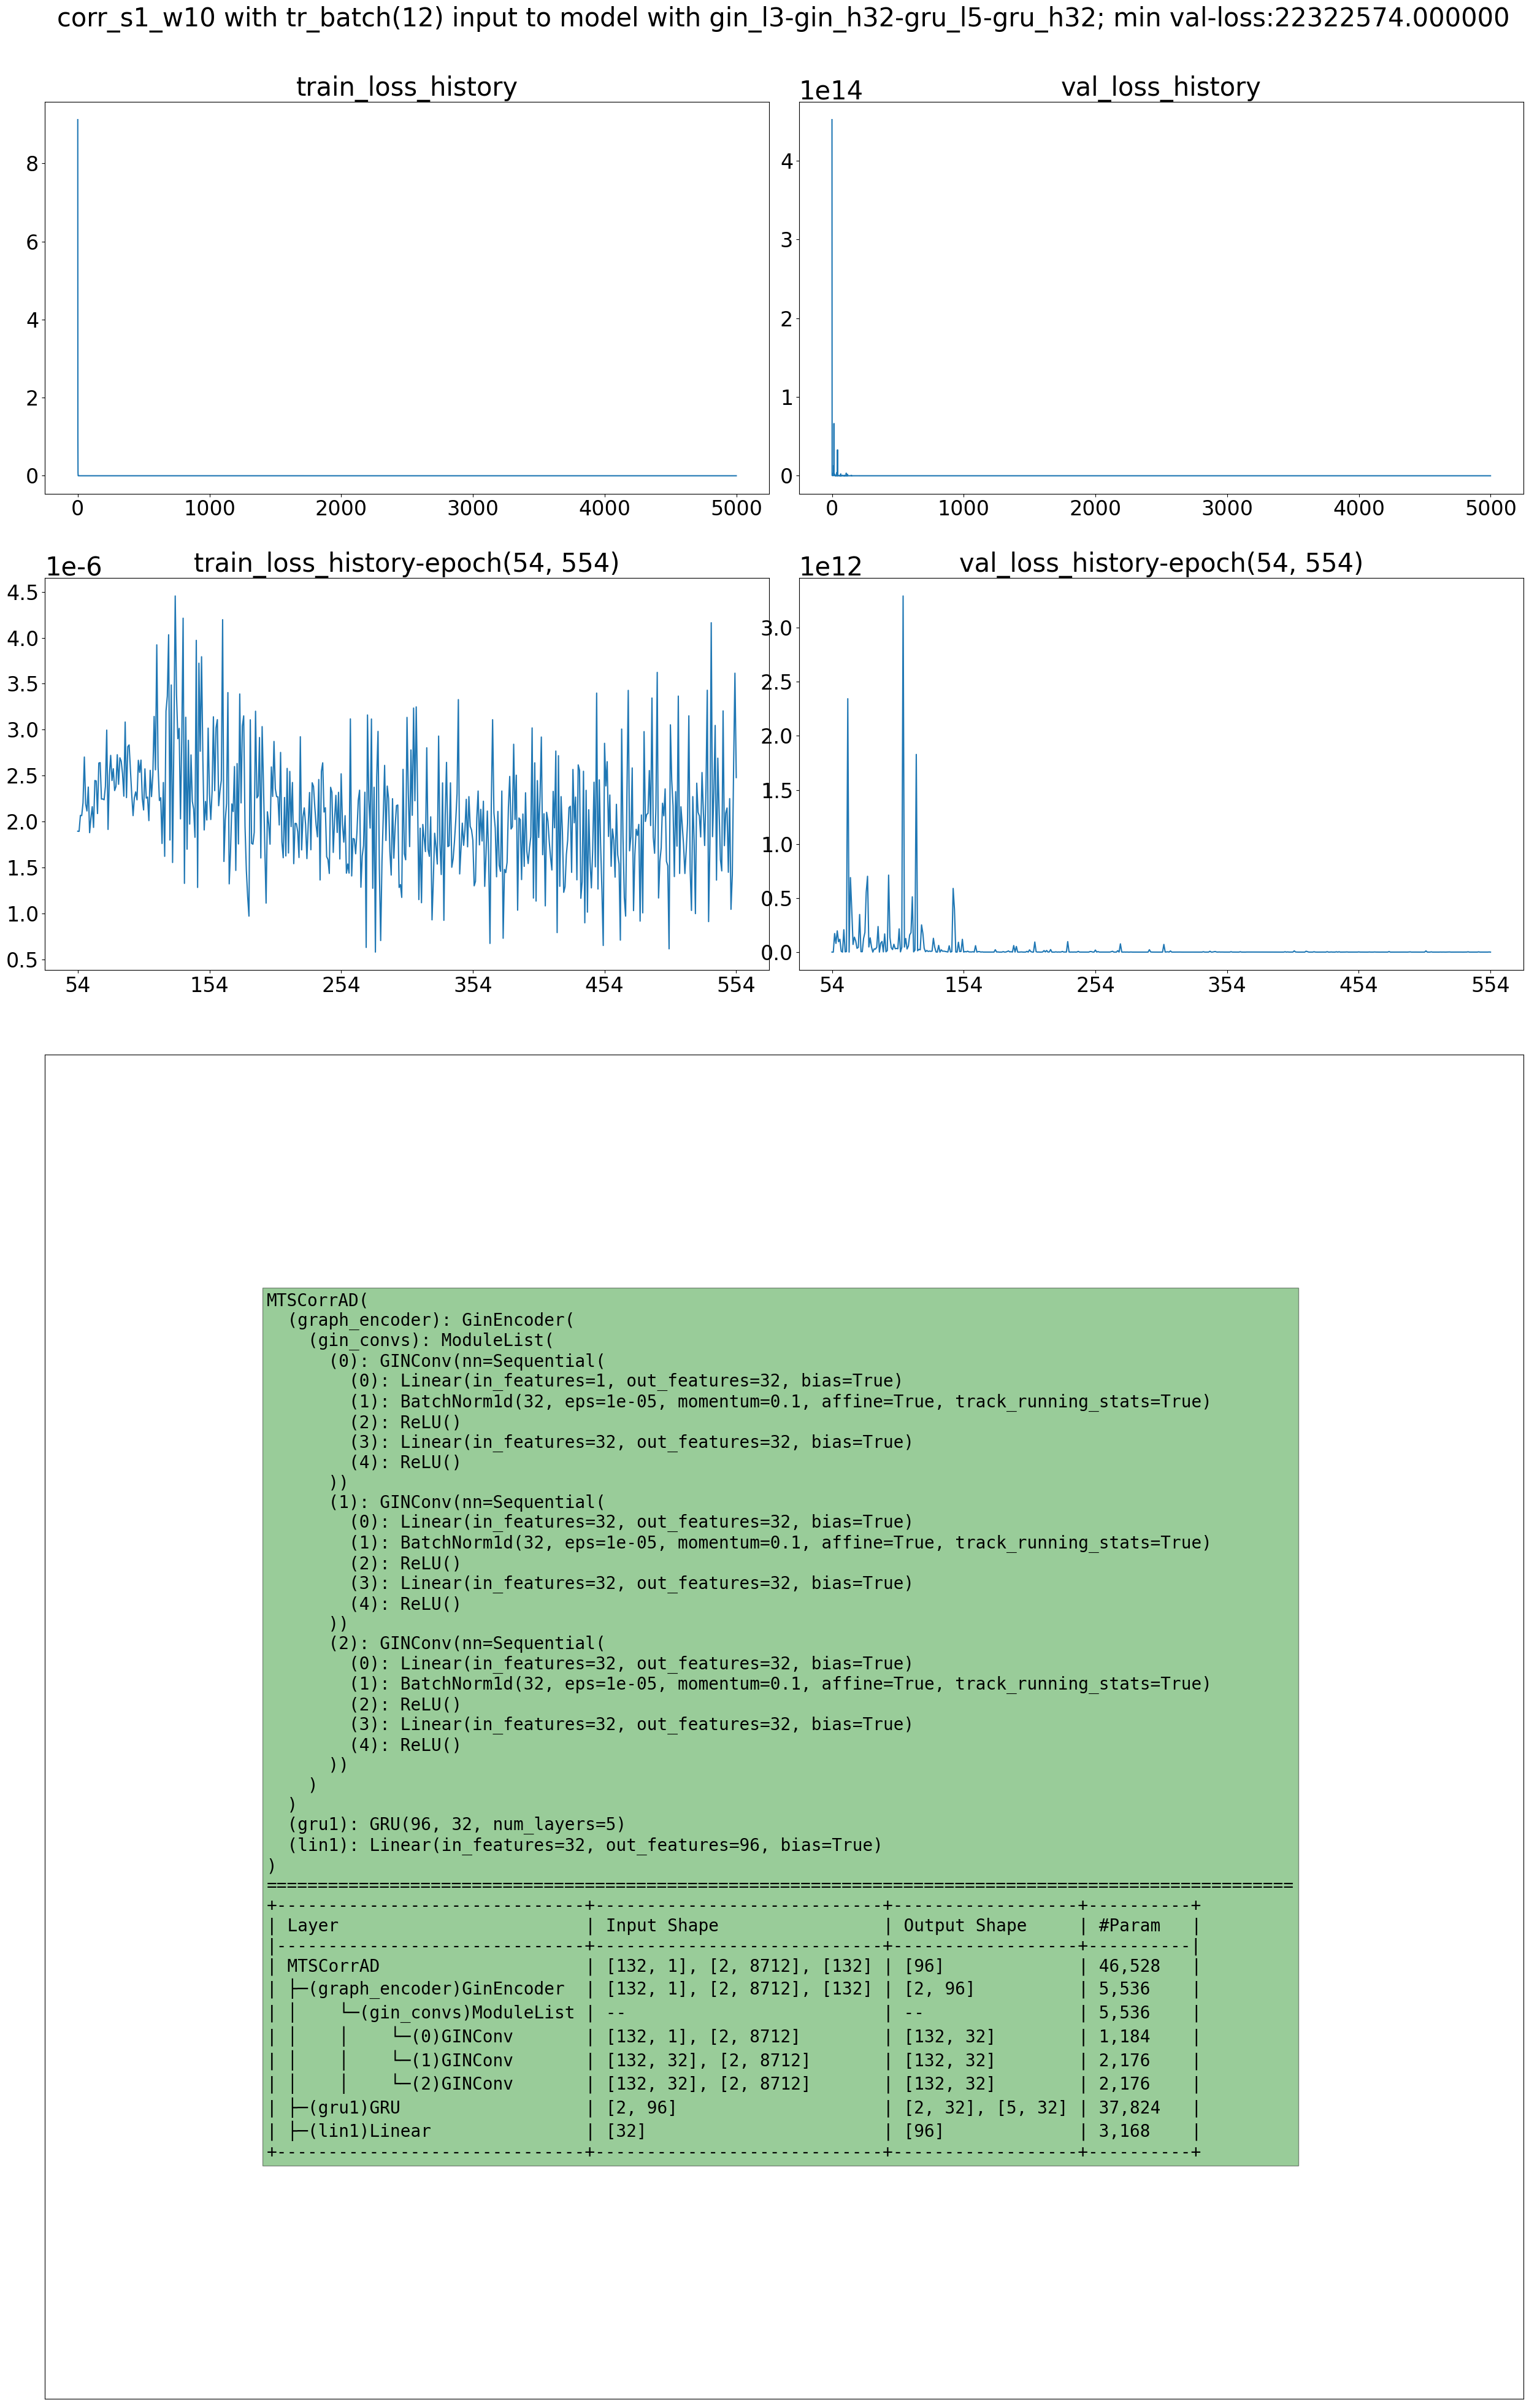

INFO     [3603277661.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_3641-20230223050435.json')


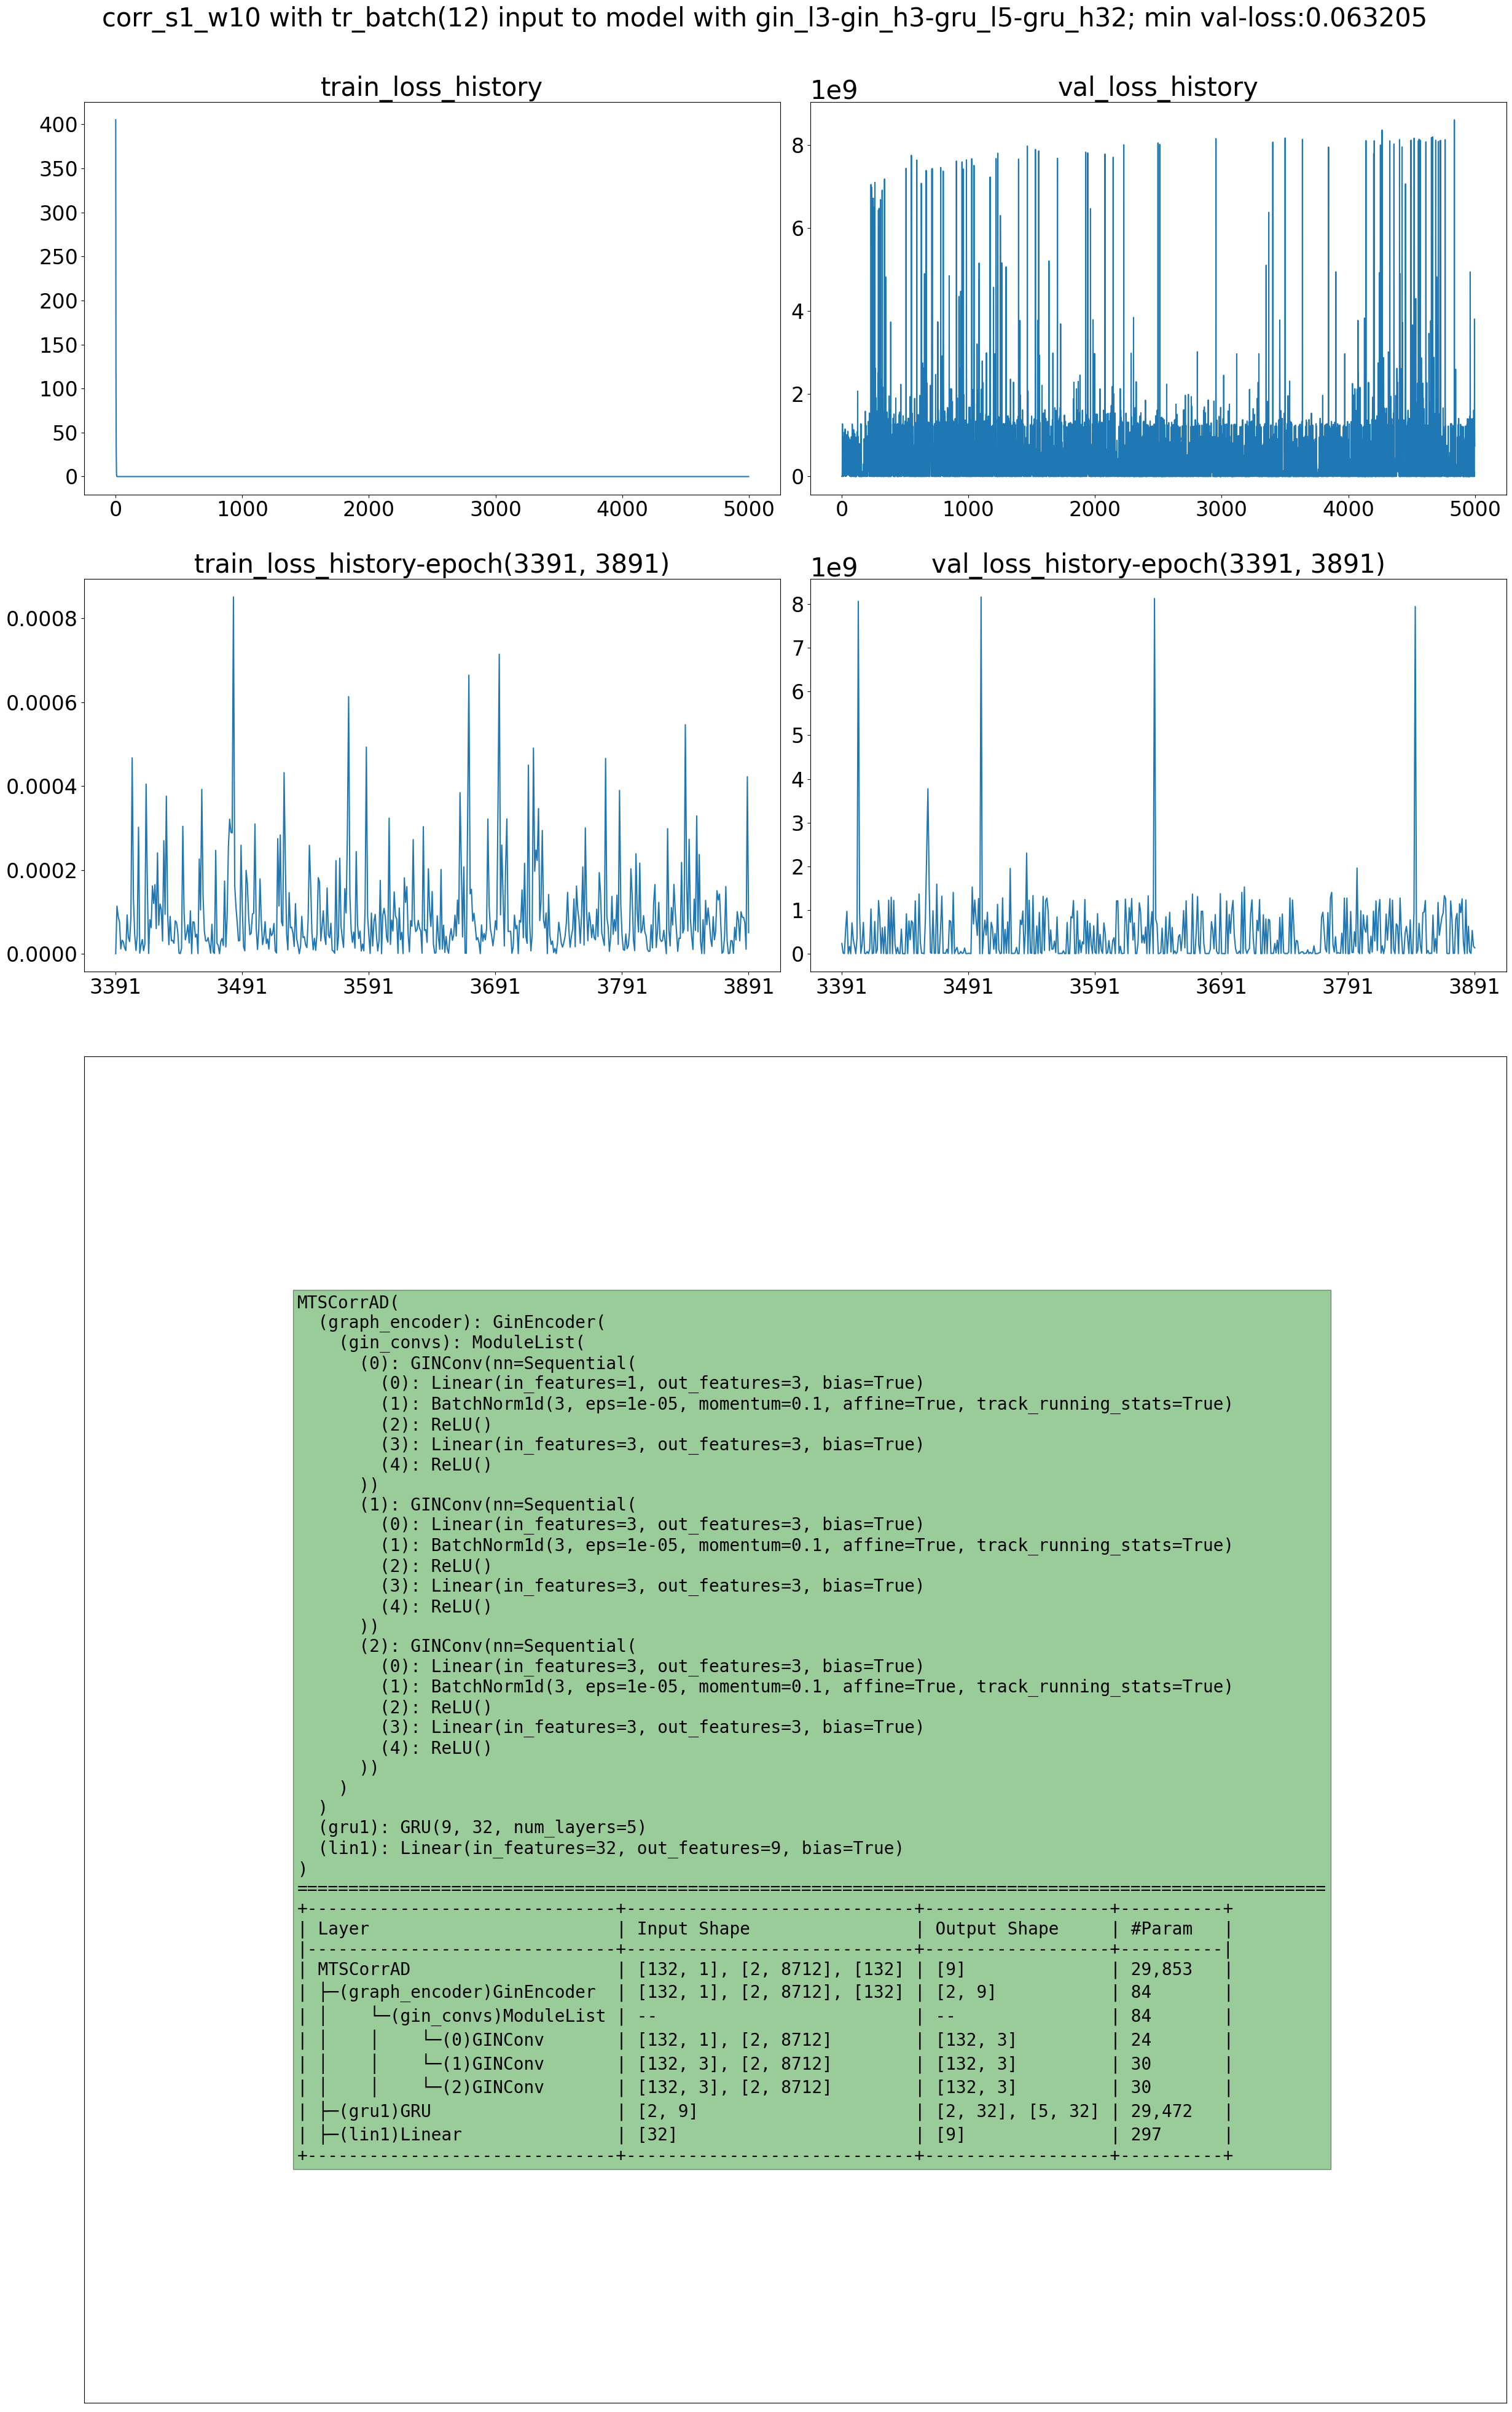

INFO     [3603277661.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_19-20230223234747.json')


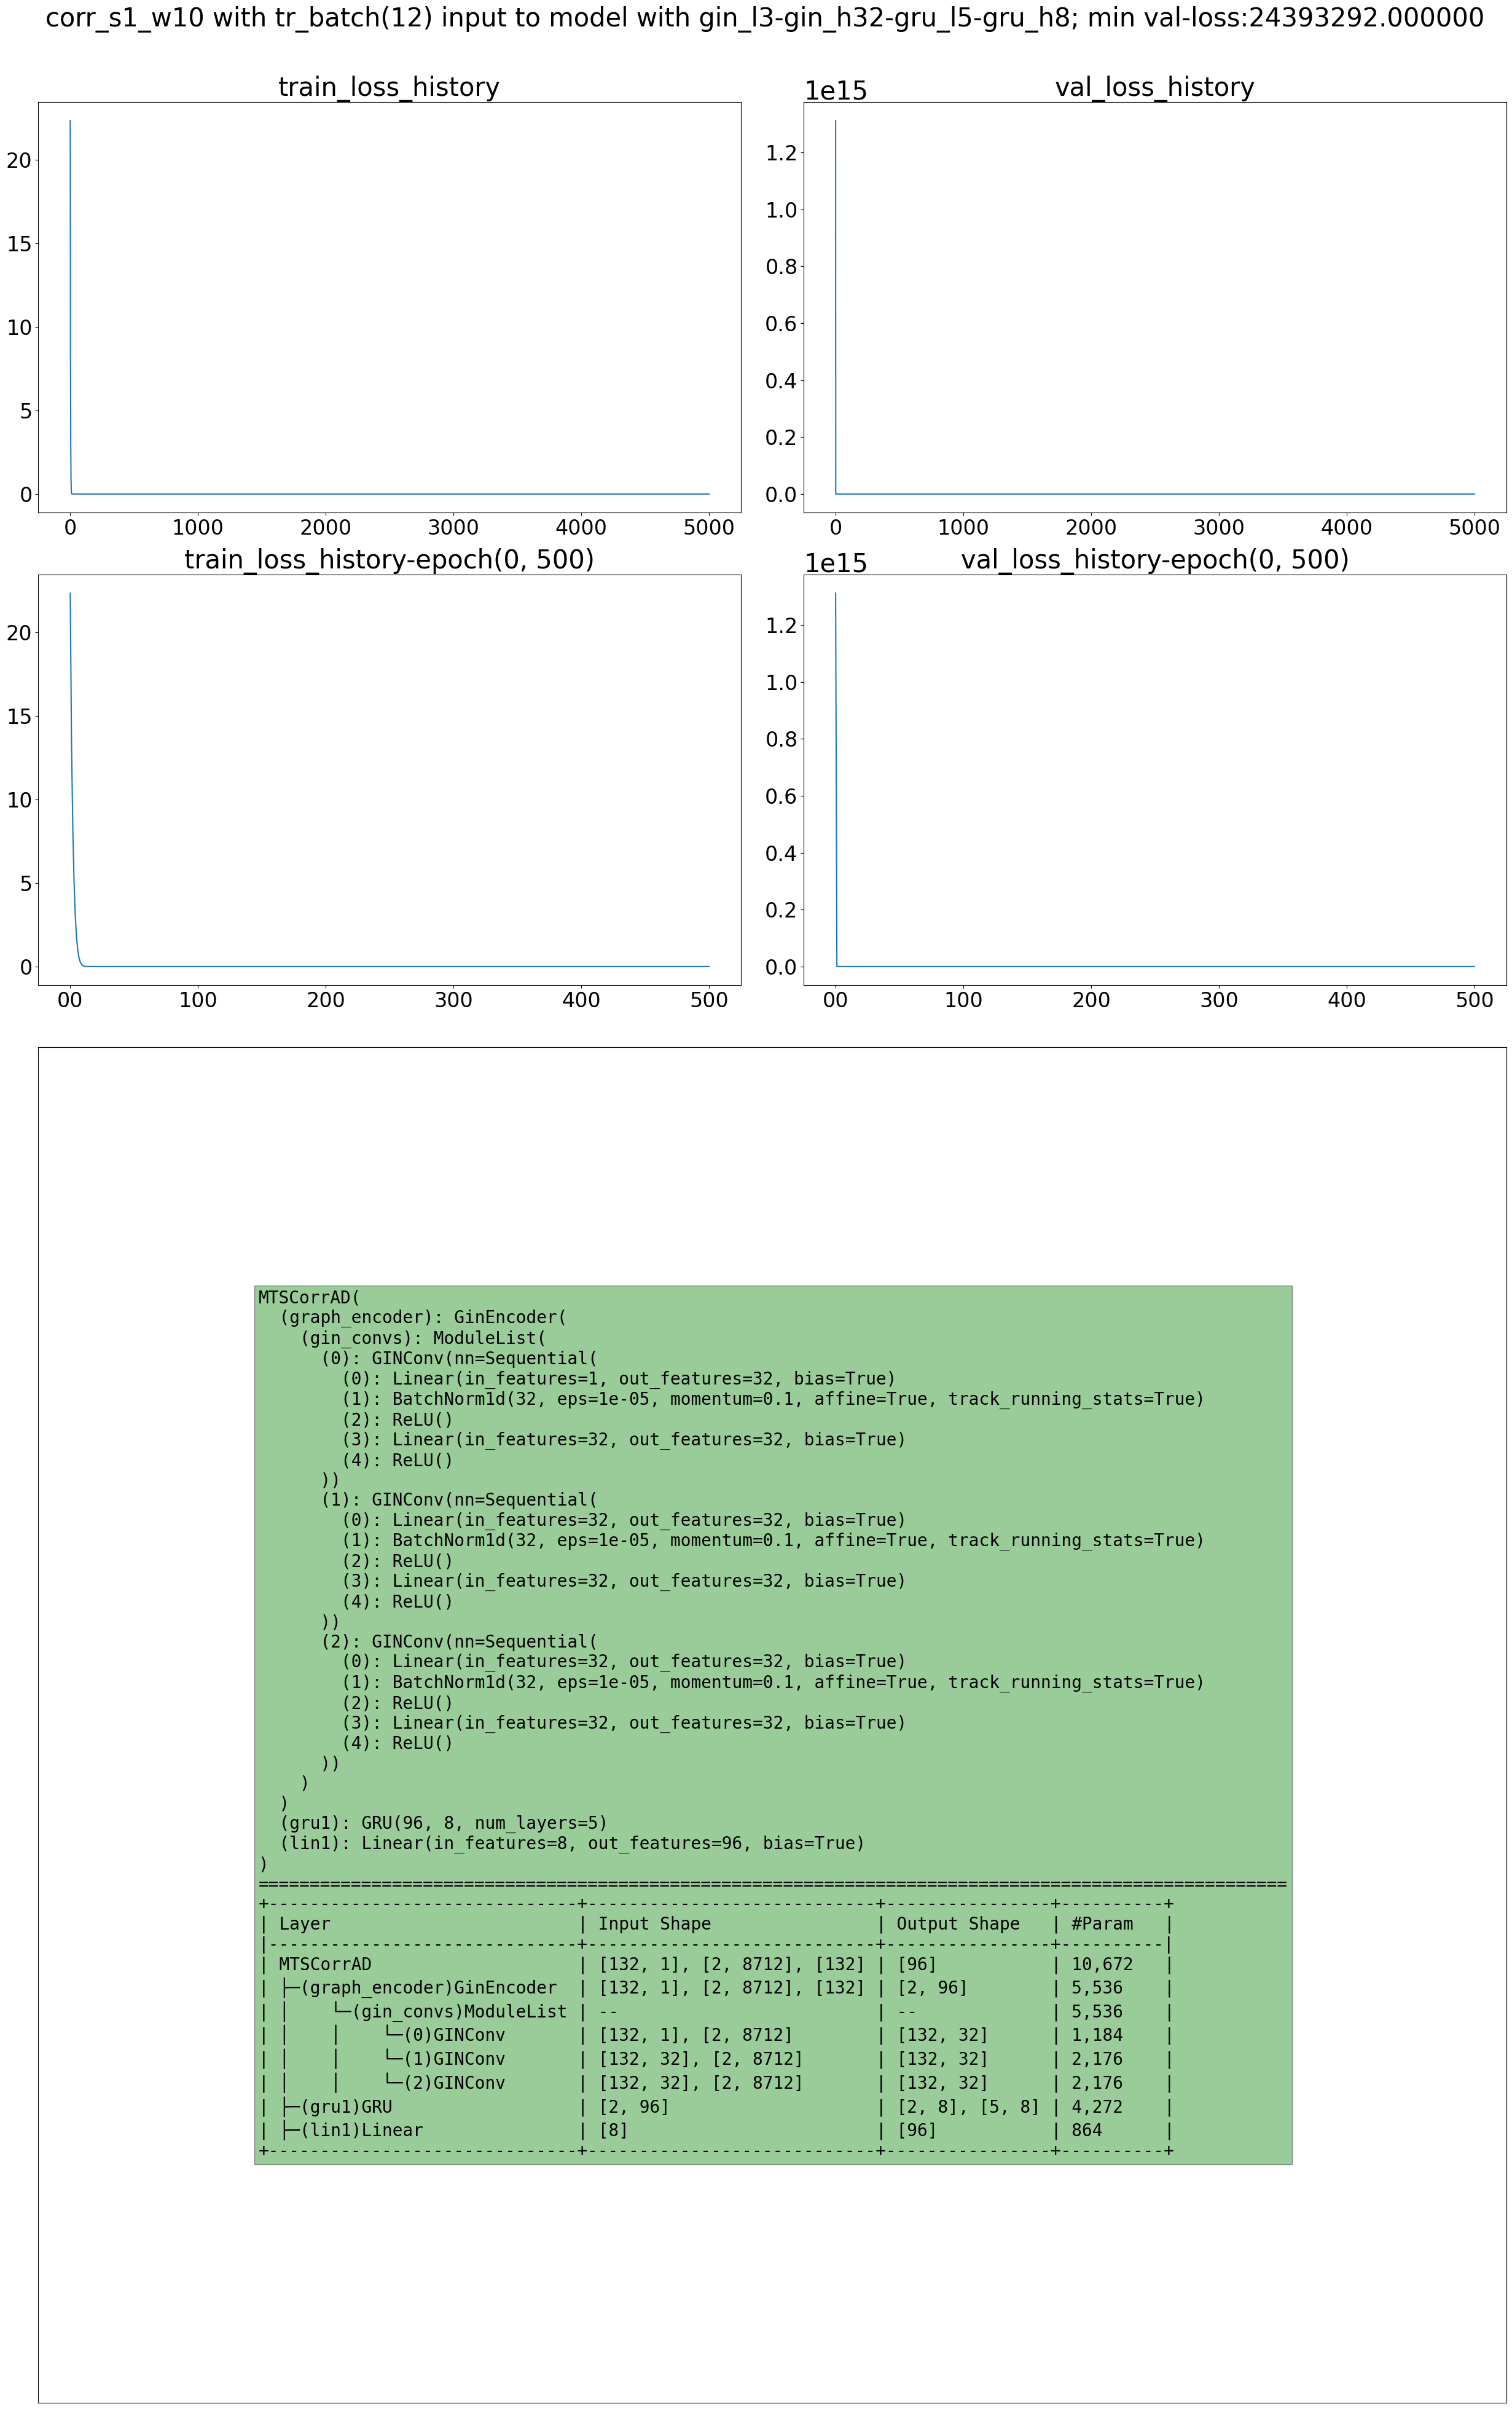

INFO     [3603277661.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_4781-20230222113929.json')


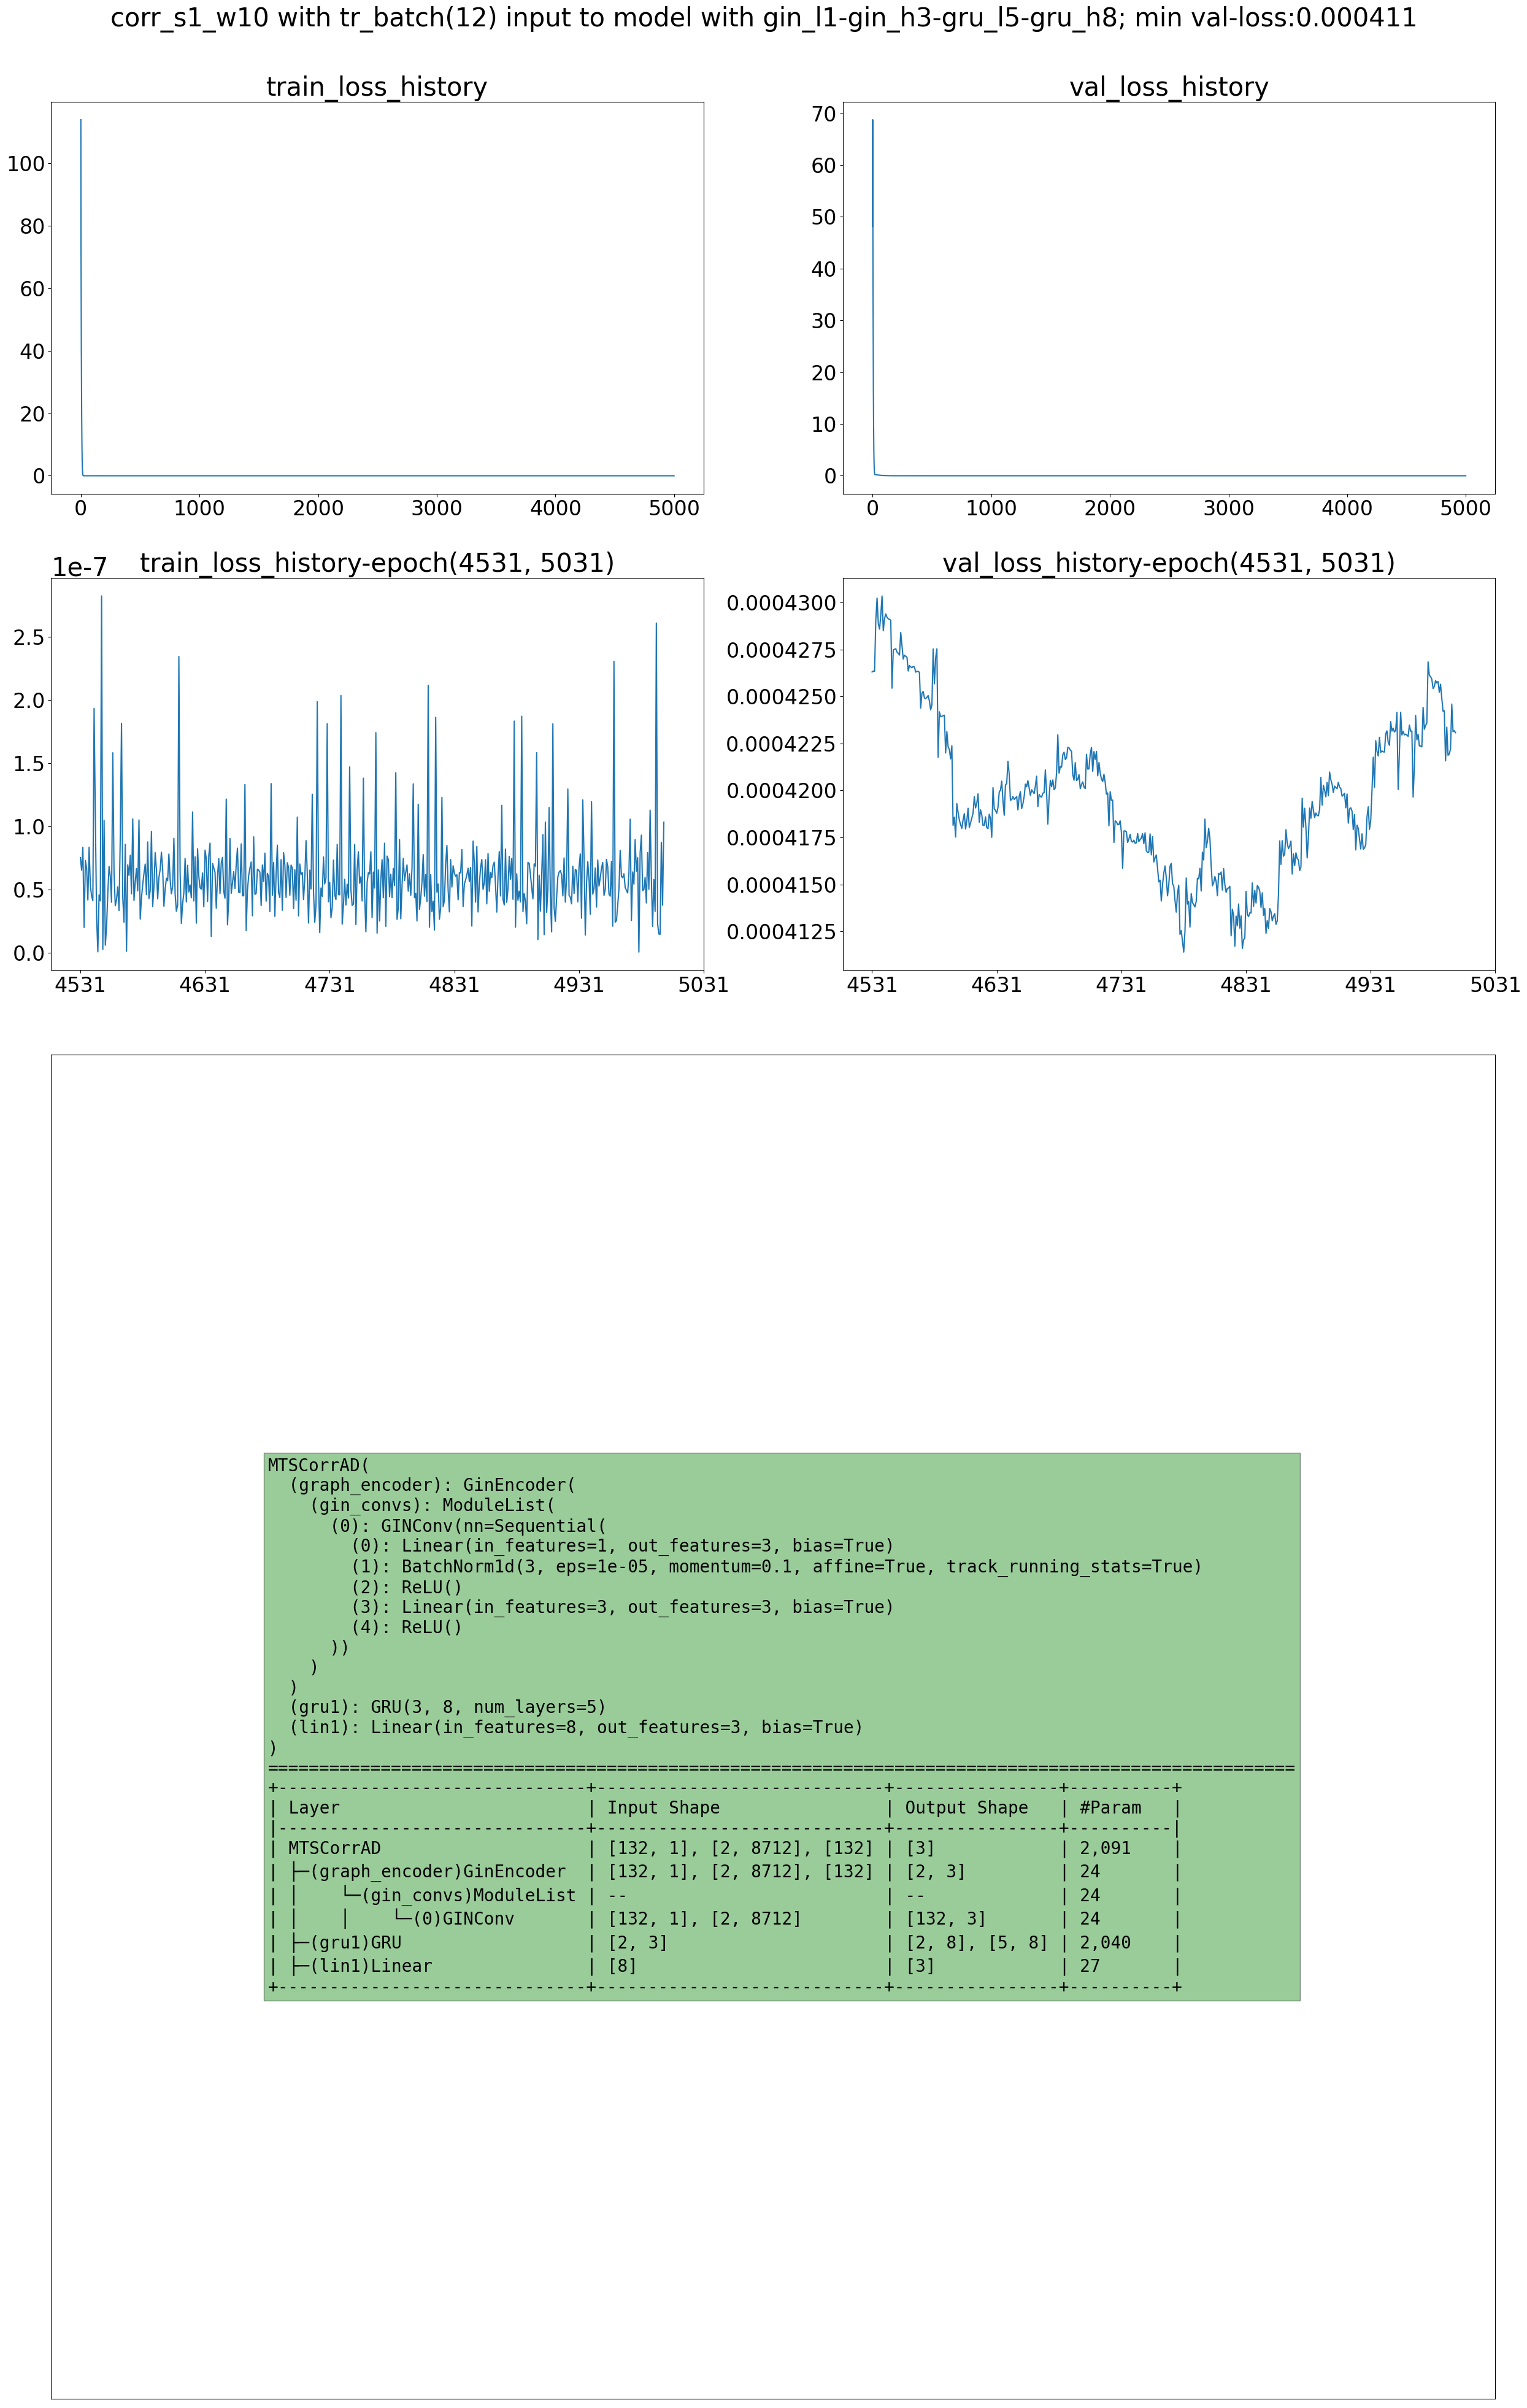

time: 4.87 s (started: 2023-02-24 01:21:25 +08:00)


In [6]:
mts_corr_model_log_dir = Path("./save_models/sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train/")
log_path_list = [p for p in mts_corr_model_log_dir.glob("./[!deprecated]*/**/*[.json]") if p.is_file()]
mts_corr_ad_estimation(log_path_list)